In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import glob
import statsmodels.api as sm
from functools import reduce

plt.style.use('ggplot')

%matplotlib inline

In [2]:
df_mkt = pd.read_excel('../data/AQR Data/Betting Against Beta Equity Factors Monthly.xlsx',\
sheet_name='MKT',header=18,index_col=0,parse_dates=True)[['USA']]
df_smb = pd.read_excel('../data/AQR Data/Betting Against Beta Equity Factors Monthly.xlsx',\
sheet_name='SMB',header=18,index_col=0,parse_dates=True)[['USA']]
df_hml = pd.read_excel('../data/AQR Data/Betting Against Beta Equity Factors Monthly.xlsx',\
sheet_name='HML FF',header=18,index_col=0,parse_dates=True)[['USA']]
df_umd = pd.read_excel('../data/AQR Data/Betting Against Beta Equity Factors Monthly.xlsx',\
sheet_name='UMD',header=18,index_col=0,parse_dates=True)[['USA']]
df_mkt.columns = ['MKT']
df_smb.columns = ['SMB']
df_hml.columns = ['HML']
df_umd.columns = ['UMD']

In [3]:
## risk-free rate
df_rf = pd.read_excel('../data/AQR Data/Betting Against Beta Equity Factors Daily.xlsx',\
sheet_name='RF',header=18,index_col=0,parse_dates=True)
df_rf_monthly = df_rf.groupby([df_rf.index.year,df_rf.index.month]).apply(lambda x: x.tail(1))
df_rf_monthly = (1+df_rf_monthly.shift(-1))**20 - 1
df_rf_monthly = df_rf_monthly.droplevel([0,1])
df_rf_monthly = df_rf_monthly.fillna(method='ffill')

In [4]:
df_factors = reduce(lambda x,y:pd.merge(x,y,how='inner',left_index=True, right_index=True),[df_mkt,df_smb,df_hml,df_umd,df_rf_monthly])
df_factors

,MKT,SMB,HML,UMD,Risk Free Rate
DATE,,,,,
1927-01-31,-0.001355,-0.006948,0.051691,0.026664,0.002499
1927-02-28,0.039274,0.003522,0.027370,-0.009261,0.002884
1927-03-31,-0.000313,-0.010440,-0.007039,0.051651,0.002403
1927-04-30,0.005255,0.009116,0.005918,0.030603,0.002884
1927-05-31,0.055110,0.015048,0.035377,0.053263,0.002499
...,...,...,...,...,...
2020-07-31,0.055872,-0.013775,-0.019973,0.069709,0.000072
2020-08-31,0.071012,-0.002214,-0.014737,-0.001434,0.000088
2020-09-30,-0.035672,0.004038,-0.014113,0.035101,0.000080


In [5]:
tickers = []
lst_rets = []
lst_betas = []
bad_tickers = list(pd.read_csv('../data/US Stocks Data/Kibor Bad Tickers/bad_ticker_v3.txt').values.flatten())
extreme_tickers = list(pd.read_csv('../data/US Stocks Data/Kibor Bad Tickers/extreme_tickers.txt').values.flatten())
bad_tickers = bad_tickers + extreme_tickers
files = glob.glob('../data/Ex Ante Beta/*')

In [6]:
for file in files:
    ticker = re.search('../data/Ex Ante Beta/(.+)\.pickle', file).group(1)
    if ticker in bad_tickers:
        continue
    lst_ret = pd.read_pickle(file)[['ret']]
    lst_beta = pd.read_pickle(file)[['beta_est']]
    
    lst_rets.append(lst_ret)
    lst_betas.append(lst_beta)
    tickers.append(ticker)
print('finished combined lst of returns and betas')
df_rets = reduce(lambda x,y:pd.merge(x,y,how='outer',left_index=True, right_index=True),lst_rets)
print('finished combined df of returns')
df_betas = reduce(lambda x,y:pd.merge(x,y,how='outer',left_index=True, right_index=True),lst_betas)
print('finished combined df of betas')
df_rets.columns = tickers
df_betas.columns = tickers

finished combined lst of returns and betas
finished combined df of returns
finished combined df of betas


In [7]:
#### BaB portfolio (daily rebalancing) ####
def portfolio_daily(beta, dailyReturnDF, rf):
    """
    daily rebalancing
    """
    betaRank = beta.rank(axis = 1) # same value: average their rank
    median = betaRank.mean(axis = 1) # average rank on each day
    k = 2 / abs(betaRank.subtract(median, axis = 0)).sum(axis = 1) # normalizing constant on each day
    w = betaRank.subtract(median, axis = 0).mul(k, axis = 0) # weight (+: high beta, -: low beta)
    
    # BaB factor
    wH = w.applymap(lambda x:x if x > 0 else 0) # relative weight assigned to low beta
    wL = w.applymap(lambda x:-x if x < 0 else 0) # relative weight assigned to high beta
    
    
    returnDFBaB = dailyReturnDF.shift(-1, axis = 0)
    portfolioDailyL = (returnDFBaB.mul(wL, axis = 1).sum(axis = 1) - rf) / (beta.mul(wL, axis = 1).sum(axis = 1))
    portfolioDailyH = (returnDFBaB.mul(wH, axis = 1).sum(axis = 1) - rf) / (beta.mul(wH, axis = 1).sum(axis = 1))
    portfolioDaily = portfolioDailyL - portfolioDailyH
    
    # adjust index
    newIdx = pd.Index(list(portfolioDaily.index)[1:])
    portfolioDaily = portfolioDaily[:-1,]

    portfolioDaily.index = newIdx
    return portfolioDaily

In [8]:
bab_daily = portfolio_daily(df_betas,df_rets, 0)

In [9]:
bab_daily.columns = ['daily return']

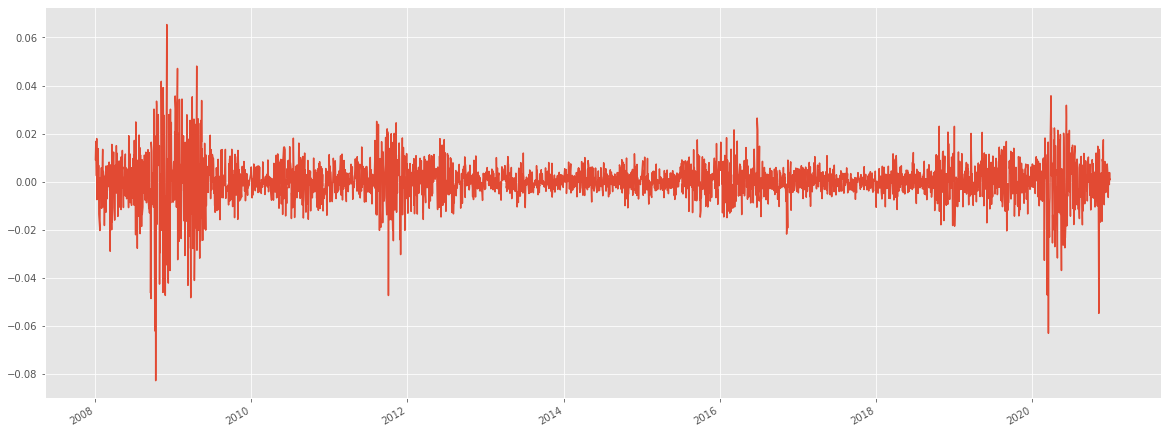

In [10]:
bab_daily.plot(figsize = (20,8))

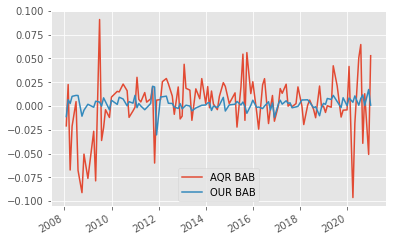

In [195]:
df_AQR_bab_daily = pd.read_excel('../data/AQR Data/Betting Against Beta Equity Factors Monthly.xlsx',\
sheet_name='BAB Factors',header=18,index_col=0,parse_dates=True)[['USA']]
df_AQR_bab = df_AQR_bab_daily[df_AQR_bab_daily.index.year > 2007]

df_bab_comparision_daily = df_AQR_bab_daily.merge(pd.DataFrame(bab_daily),left_index = True, right_index=True)
df_bab_comparision_daily.columns = ['AQR BAB','OUR BAB']
df_bab_comparision_daily.plot()

In [11]:
def monthly_returns(df):
    """
    monthly returns
    """
    total_return_from_returns = lambda returns:(returns + 1).prod() - 1 # Returns the return between the first and last value of the DataFrame
    monthlyReturn = lambda series:series.groupby([series.index.year, series.index.month])\
    .apply(total_return_from_returns)

    monthlyReturnDF = df.apply(monthlyReturn, axis = 0)
    
    return monthlyReturnDF

In [12]:
monthly_rets_df = monthly_returns(df_rets)
monthly_rets_df 

CJ     WHLRP       DEO        GY      TGNA      MMSI      QCOM  \
2007 12  0.0  0.000000 -0.006536 -0.006098  0.020886 -0.025868 -0.003637   
2008 1   0.0  0.000000 -0.063531 -0.011808 -0.067034  0.144374  0.053448   
     2   0.0  0.000000  0.011784 -0.120669 -0.185112 -0.021579  0.008884   
     3   0.0  0.000000 -0.001259 -0.025597 -0.033318 -0.008139 -0.041474   
     4   0.0  0.000000  0.004824 -0.173134 -0.027863 -0.076374  0.049528   
...      ...       ...       ...       ...       ...       ...       ...   
2020 8   0.0  0.167402 -0.075275  0.000000  0.057908  0.093748  0.122669   
     9   0.0 -0.088784  0.018354  0.000000 -0.061634 -0.123513 -0.013678   
     10  0.0  0.089420 -0.056251  0.000000  0.017574  0.144882  0.043544   
     11  0.0  0.037247  0.182262  0.000000  0.189845  0.095735  0.180968   
     12  0.0  0.166270  0.023405  0.000000 -0.029130  0.003799  0.032599   

             ESRX       UAM       PKX  ...        FF       JRI  ALL.E  \
2007 12  0.000151  0.009130 -0.024685  ...  0.000000  0.000000    0.0   
2008 1  -0.084055 -0.190983 -0.107750  ...  0.000000  0.000000    0.0   
     2  -0.130546 -0.190689 -0.012173  ...  0.000000  0.000000    0.0   
     3   0.079929 -0.415695 -0.133663  ...  0.000000  0.000000    0.0   
     4   0.080631 -0.003808  0.025356  ...  0.000000  0.000000    0.0   
...           ...       ...       ...  ...       ...       ...    ...   
2020 8   0.000000  0.000000 -0.040438  ... -0.084356  0.012132    0.0   
     9   0.000000  0.000000  0.079659  ... -0.070446 -0.007282    0.0   
     10  0.000000  0.000000  0.099626  ...  0.041692 -0.030440    0.0   
     11  0.000000  0.000000  0.145844  ...  0.005190  0.135176    0.0   
     12  0.000000  0.000000  0.162896  ...  0.053850  0.031941    0.0   

              TDA       CEB      CORR       RES  IPL.D      ARQL      DOGZ  
2007 12  0.000000 -0.008668  0.000000 -0.030404    0.0  0.008535  0.000000  
2008 1   0.000000 -0.050845  0.000000 -0.099224    0.0 -0.187805  0.000000  
     2   0.000000 -0.327243  0.000000  0.216833    0.0 -0.073175  0.000000  
     3   0.000000  0.003529  0.000000  0.137710    0.0 -0.078729  0.000000  
     4   0.000000  0.066102  0.000000 -0.180393    0.0 -0.114243  0.000000  
...           ...       ...       ...       ...    ...       ...       ...  
2020 8   0.020292  0.000000  0.007281  0.040466    0.0  0.000000  0.000000  
     9   0.019654  0.000000 -0.363103 -0.179091    0.0  0.000000  0.000000  
     10 -0.027103  0.000000 -0.214793 -0.108120    0.0  0.000000  0.000000  
     11  0.029413  0.000000  0.167515  0.234154    0.0  0.000000  0.000000  
     12 -0.003246  0.000000  0.111715  0.022099    0.0  0.000000  0.079995  

[157 rows x 7584 columns]

In [13]:
def portfolio_monthly(beta, monthlyReturnDF, rf = 0):
    betaRank = beta.rank(axis = 1) # same value: average their rank
    median = betaRank.mean(axis = 1) # average rank on each day
    k = 2 / abs(betaRank.subtract(median, axis = 0)).sum(axis = 1) # normalizing constant on each day
    w = betaRank.subtract(median, axis = 0).mul(k, axis = 0) # weight (+: high beta, -: low beta)
    
    tail = lambda x:x.tail(1)
    monthly = lambda x:x.groupby([x.index.year, x.index.month]).apply(tail)
    wMonthly = w.apply(monthly, axis = 0)
    betaMonthly = beta.apply(monthly, axis = 0)

    wMonthlyL = wMonthly.applymap(lambda x:-x if x < 0 else 0) # relative weight assigned to high beta
    wMonthlyH = wMonthly.applymap(lambda x:x if x > 0 else 0) # relative weight assigned to low beta


    monthlyIdx = wMonthly.index & betaMonthly.index
    monthlyReturnDFBaB = monthlyReturnDF.loc[monthlyIdx, ].shift(-1, axis = 0)


    portfolioMonthlyL = (monthlyReturnDFBaB.mul(wMonthlyL, axis = 1).sum(axis = 1) - rf) / (betaMonthly.mul(wMonthlyL, axis = 1).sum(axis = 1))
    portfolioMonthlyH = (monthlyReturnDFBaB.mul(wMonthlyH, axis = 1).sum(axis = 1) - rf) / (betaMonthly.mul(wMonthlyH, axis = 1).sum(axis = 1))
    portfolioMonthly = portfolioMonthlyL - portfolioMonthlyH
    
    # adjust index
    newIdx = pd.Index(list(portfolioMonthly.index)[1:])
    portfolioMonthly = portfolioMonthly[:-1,]

    portfolioMonthly.index = newIdx
    
    # reset index ( to datetime)
    portfolioMonthly.index = portfolioMonthly.index.droplevel([0,1]) 
    
    return portfolioMonthly

In [14]:
bab_monthly = portfolio_monthly(df_betas, monthly_rets_df)

In [15]:
bab_monthly.columns = ['monthly return']

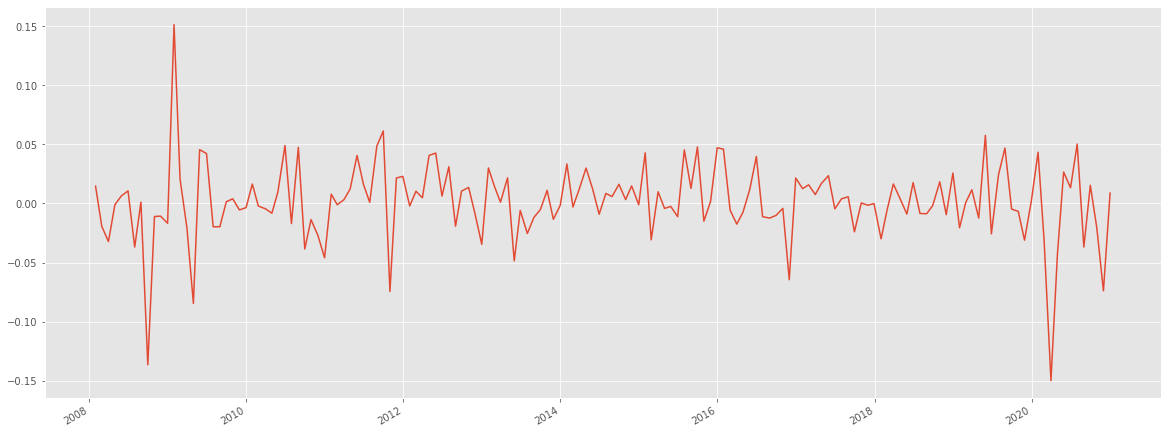

In [16]:
bab_monthly.plot(figsize = (20,8))

In [184]:
df_AQR_bab = pd.read_excel('../data/AQR Data/Betting Against Beta Equity Factors Monthly.xlsx',\
sheet_name='BAB Factors',header=18,index_col=0,parse_dates=True)[['USA']]
df_AQR_bab = df_AQR_bab[df_AQR_bab.index.year > 2007]
df_AQR_bab 

,USA
DATE,
2008-01-31,-0.020861
2008-02-29,0.022633
2008-03-31,-0.067268
2008-04-30,-0.021194
2008-05-31,0.009018
...,...
2020-08-31,-0.039206
2020-09-30,0.012971
2020-10-31,-0.019902


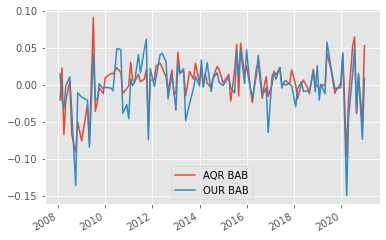

In [193]:
df_bab_comparision_monthly = df_AQR_bab.merge(pd.DataFrame(bab_monthly),left_index = True, right_index=True)
df_bab_comparision_monthly.columns = ['AQR BAB','OUR BAB']
df_bab_comparision_monthly.plot()

In [17]:
#### Equal-weighted BaB portfolio (monthly rebalancing) ####
def portfolio_monthly_equal_weighted(idx, beta, monthlyReturnDF):
    beta = beta.dropna(how = 'all', axis = 0)
    median = beta.mean(axis = 1) # average rank on each day
    
    # assign weight to those whose beta larger than mean
    compare_1 = lambda x: 1 if x else 0
    assign_1 = lambda x: (x > median).apply(compare_1)
    tmp_w = beta.apply(assign_1, axis = 0)
    
    avg = lambda x: x.divide(tmp_w.sum(axis = 1))
    wH = tmp_w.apply(avg, axis = 0)
    
    
    # assign weight to those whose beta lower than mean
    compare_2 = lambda x: 1 if x else 0
    assign_2 = lambda x: (x <= median).apply(compare_2)
    tmp_w = beta.apply(assign_2, axis = 0)
    
    avg_2 = lambda x: x.divide(tmp_w.sum(axis = 1))
    wL = tmp_w.apply(avg_2, axis = 0)
    
    w = wL - wH
    
    # monthly
    tail = lambda x:x.tail(1)
    
    monthly = lambda x:x.groupby([x.index.year, x.index.month]).apply(tail)
    wMonthly = w.apply(monthly, axis = 0)
    betaMonthly = beta.apply(monthly, axis = 0)

    # pick monthly return
    monthlyIdx = wMonthly.index & betaMonthly.index
    monthlyReturnDFBaB = monthlyReturnDF.loc[monthlyIdx, ].shift(-1, axis = 0)
    
    portfolioMonthly = (monthlyReturnDFBaB * wMonthly).sum(axis = 1)

    
    # adjust index
    newIdx = pd.Index(list(portfolioMonthly.index)[1:])
    portfolioMonthly = portfolioMonthly[:-1,]

    portfolioMonthly.index = newIdx
    
    # reset index ( to datetime)
    portfolioMonthly.index = portfolioMonthly.index.droplevel([0,1]) 
    
    return portfolioMonthly

In [18]:
#### Equal-weighted quantile portfolio (monthly rebalancing) ####
def portfolio_monthly_equal_weighted_quantile(beta, monthlyReturnDF):
    #beta = beta.dropna(how = 'all', axis = 0)
    
    quantiles_portfolio = []
    betas_ex_ante = pd.DataFrame(index = ['Beta_ex_ante'])

    
    # assign weight to each quantile
    for idx,quantile in enumerate(np.arange(0,1,0.1),start = 1):
        low = beta.quantile(quantile, axis = 1)
        high = beta.quantile(quantile + 0.1, axis = 1)
        compare_1 = lambda x: 1 if x else 0
        assign_1 = lambda x: ((x >= low) & (x < high)).apply(compare_1)
        tmp_w = beta.apply(assign_1, axis = 0)
    
        avg = lambda x: x.divide(tmp_w.sum(axis = 1))
        w = tmp_w.apply(avg, axis = 0)
        
        #ex ante beta
        betas_ex_ante['P' + str(idx)] = (beta * w).sum(axis = 1).mean()
    
    
            # monthly
        tail = lambda x:x.tail(1)

        monthly = lambda x:x.groupby([x.index.year, x.index.month]).apply(tail)
        wMonthly = w.apply(monthly, axis = 0)

        betaMonthly = beta.apply(monthly, axis = 0)
        

        # pick monthly return
        monthlyIdx = wMonthly.index & betaMonthly.index
        monthlyReturnDFBaB = monthlyReturnDF.loc[monthlyIdx, ].shift(-1, axis = 0)

        portfolioMonthly = (monthlyReturnDFBaB * wMonthly).sum(axis = 1)


        # adjust index
        newIdx = pd.Index(list(portfolioMonthly.index)[1:])
        portfolioMonthly = portfolioMonthly[:-1,]

        portfolioMonthly.index = newIdx

        # reset index ( to datetime)
        portfolioMonthly.index = portfolioMonthly.index.droplevel([0,1])
        
        quantiles_portfolio.append(pd.DataFrame(portfolioMonthly, columns = ['P' + str(idx)]))
        print(idx)
    
    
    df_quantiles = reduce(lambda x,y:pd.merge(x,y,left_index=True, right_index=True),quantiles_portfolio)
        
        
    
    return df_quantiles, betas_ex_ante

In [19]:
df_quantiles, betas_ex_ante = portfolio_monthly_equal_weighted_quantile(df_betas, monthly_rets_df)
df_quantiles

1
2
3
4
5
6
7
8
9
10


,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10
2008-01-31,0.023110,-0.038493,-0.067202,-0.061176,-0.074540,-0.067185,-0.063140,-0.062530,-0.072583,-0.064984
2008-02-29,-0.042214,-0.021336,-0.017762,-0.027488,-0.042030,-0.028429,-0.053016,-0.044889,-0.041304,-0.022748
2008-03-31,0.001365,-0.046651,-0.028912,-0.032608,-0.025496,-0.010130,-0.014699,-0.001982,-0.010356,-0.007401
2008-04-30,0.013590,0.026646,0.015824,0.019809,0.041596,0.034968,0.036447,0.023714,0.036598,0.051163
2008-05-30,0.011019,0.014360,0.019205,0.031147,0.027917,0.036255,0.020798,0.027237,0.023486,0.029837
...,...,...,...,...,...,...,...,...,...,...
2020-08-31,0.001581,0.007383,0.014954,0.023929,0.036360,0.039698,0.038371,0.054097,0.058461,0.080700
2020-09-30,-0.005071,-0.022084,-0.026238,-0.030722,-0.035094,-0.036083,-0.039711,-0.043973,-0.049147,-0.065475
2020-10-30,-0.014685,-0.000563,-0.007947,-0.000277,-0.012368,0.008581,0.012459,0.014389,0.018657,0.002547
2020-11-30,0.045309,0.069846,0.104065,0.120539,0.136341,0.157655,0.177720,0.193503,0.219129,0.289174


In [87]:
df_quantiles['P11'] = (df_quantiles[['P1','P2','P3','P4','P5']].sum(axis = 1) - df_quantiles[['P6','P7','P8','P9','P10']].sum(axis=1))/5
df_quantiles['P12'] = bab_monthly
df_quantiles

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12
Date,,,,,,,,,,,,
2008-01-31,0.023110,-0.038493,-0.067202,-0.061176,-0.074540,-0.067185,-0.063140,-0.062530,-0.072583,-0.064984,0.022424,0.014677
2008-02-29,-0.042214,-0.021336,-0.017762,-0.027488,-0.042030,-0.028429,-0.053016,-0.044889,-0.041304,-0.022748,0.007911,-0.019325
2008-03-31,0.001365,-0.046651,-0.028912,-0.032608,-0.025496,-0.010130,-0.014699,-0.001982,-0.010356,-0.007401,-0.017546,-0.032221
2008-04-30,0.013590,0.026646,0.015824,0.019809,0.041596,0.034968,0.036447,0.023714,0.036598,0.051163,-0.013085,-0.000993
2008-05-30,0.011019,0.014360,0.019205,0.031147,0.027917,0.036255,0.020798,0.027237,0.023486,0.029837,-0.006793,0.006405
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-31,0.001581,0.007383,0.014954,0.023929,0.036360,0.039698,0.038371,0.054097,0.058461,0.080700,-0.037424,-0.036874
2020-09-30,-0.005071,-0.022084,-0.026238,-0.030722,-0.035094,-0.036083,-0.039711,-0.043973,-0.049147,-0.065475,0.023036,0.015407
2020-10-30,-0.014685,-0.000563,-0.007947,-0.000277,-0.012368,0.008581,0.012459,0.014389,0.018657,0.002547,-0.018495,-0.020346


In [172]:
### ex-ante betas
betas_ex_ante['P11'] = (betas_ex_ante[['P1','P2','P3','P4','P5']].sum(axis=1).values[0] - betas_ex_ante[['P6','P7','P8','P9','P10']].sum(axis=1).values[0])/5
betas_ex_ante['P12'] = 0
betas_ex_ante

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12
Beta_ex_ante,0.477368,0.604875,0.741436,0.845171,0.92543,1.000128,1.078392,1.165814,1.27998,1.537161,-0.493439,0


In [173]:
# df_quantiles = df_quantiles.merge(df_rf_monthly, left_index = True, right_index = True)
# df_quantiles = df_quantiles - df_quantiles[['Risk Free Rate']].values
# df_quantiles = df_quantiles.drop('Risk Free Rate', axis = 1)
df_quantiles

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12
Date,,,,,,,,,,,,
2008-01-31,0.023110,-0.038493,-0.067202,-0.061176,-0.074540,-0.067185,-0.063140,-0.062530,-0.072583,-0.064984,0.022424,0.014677
2008-02-29,-0.042214,-0.021336,-0.017762,-0.027488,-0.042030,-0.028429,-0.053016,-0.044889,-0.041304,-0.022748,0.007911,-0.019325
2008-03-31,0.001365,-0.046651,-0.028912,-0.032608,-0.025496,-0.010130,-0.014699,-0.001982,-0.010356,-0.007401,-0.017546,-0.032221
2008-04-30,0.013590,0.026646,0.015824,0.019809,0.041596,0.034968,0.036447,0.023714,0.036598,0.051163,-0.013085,-0.000993
2008-05-30,0.011019,0.014360,0.019205,0.031147,0.027917,0.036255,0.020798,0.027237,0.023486,0.029837,-0.006793,0.006405
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-31,0.001581,0.007383,0.014954,0.023929,0.036360,0.039698,0.038371,0.054097,0.058461,0.080700,-0.037424,-0.036874
2020-09-30,-0.005071,-0.022084,-0.026238,-0.030722,-0.035094,-0.036083,-0.039711,-0.043973,-0.049147,-0.065475,0.023036,0.015407
2020-10-30,-0.014685,-0.000563,-0.007947,-0.000277,-0.012368,0.008581,0.012459,0.014389,0.018657,0.002547,-0.018495,-0.020346


In [174]:
## excess return
df_excess_ret = pd.DataFrame(df_quantiles.mean() * 12 * 100).T 
df_excess_ret.columns = ['P' + str(i) for i in range(1,13)]
df_excess_ret.index = ['Excess return']
df_excess_ret

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12
Excess return,2.255421,2.069342,3.797852,3.216768,4.372822,4.32355,3.326436,3.192901,1.564709,3.047748,0.051372,1.814425


In [181]:
df_factors

,MKT,SMB,HML,UMD,Risk Free Rate
DATE,,,,,
1927-01-31,-0.001355,-0.006948,0.051691,0.026664,0.002499
1927-02-28,0.039274,0.003522,0.027370,-0.009261,0.002884
1927-03-31,-0.000313,-0.010440,-0.007039,0.051651,0.002403
1927-04-30,0.005255,0.009116,0.005918,0.030603,0.002884
1927-05-31,0.055110,0.015048,0.035377,0.053263,0.002499
...,...,...,...,...,...
2020-07-31,0.055872,-0.013775,-0.019973,0.069709,0.000072
2020-08-31,0.071012,-0.002214,-0.014737,-0.001434,0.000088
2020-09-30,-0.035672,0.004038,-0.014113,0.035101,0.000080


In [175]:
##capm
df_capm =  pd.DataFrame(index = ['CAPM alpha'])
model_data = df_quantiles.merge(df_factors, left_index = True, right_index = True)
model_data.columns = ['P' + str(i) for i in range(1,13)] +['MKT','SMB','HML','UMD','Risk Free Rate']
for idx in [i for i in range(1,13)]:

    exog = model_data[['MKT']]
    exog = sm.add_constant(exog)
    endog = model_data['P' + str(idx)]
    # Fit and summarize OLS model
    mod = sm.OLS(endog, exog)

    res = mod.fit()
    df_capm['P' + str(idx)] = res.params[0] * 100

df_capm

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12
CAPM alpha,-0.120299,-0.458043,-0.464056,-0.610973,-0.569736,-0.613606,-0.729904,-0.806238,-1.022581,-1.037364,0.397317,0.075324


In [176]:
##Three-factor alpha
df_three_factors_alpha =  pd.DataFrame(index = ['Three-factor alpha'])
model_data = df_quantiles.merge(df_factors, left_index = True, right_index = True)
model_data.columns = ['P' + str(i) for i in range(1,13)] + ['MKT','SMB','HML','UMD','Risk Free Rate']
for idx in np.arange(1,13):

    exog = model_data[['MKT','SMB','HML']]
    exog = sm.add_constant(exog)
    endog = model_data['P' + str(idx)]
    # Fit and summarize OLS model
    mod = sm.OLS(endog, exog)

    res = mod.fit()
    df_three_factors_alpha['P' + str(idx)] = res.params[0] * 100

df_three_factors_alpha

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12
Three-factor alpha,-0.058867,-0.360373,-0.334094,-0.486929,-0.450777,-0.477743,-0.564864,-0.625522,-0.78851,-0.677231,0.288566,0.039379


In [177]:
### Four-factor alpha

df_four_factors_alpha =  pd.DataFrame(index = ['Four-factor alpha'])
model_data = df_quantiles.merge(df_factors, left_index = True, right_index = True)
model_data.columns = ['P' + str(i) for i in range(1,13)] + ['MKT','SMB','HML','UMD','Risk Free Rate']
for idx in np.arange(1,13):

    exog = model_data[['MKT','SMB','HML','UMD']]
    exog = sm.add_constant(exog)
    endog = model_data['P' + str(idx)]
    # Fit and summarize OLS model
    mod = sm.OLS(endog, exog)

    res = mod.fit()
    df_four_factors_alpha['P' + str(idx)] = res.params[0] * 100

df_four_factors_alpha

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12
Four-factor alpha,-0.056276,-0.364411,-0.343483,-0.495717,-0.454958,-0.479213,-0.564665,-0.620287,-0.778975,-0.652997,0.276258,0.019337


In [178]:
### Beta (realized)

beta_realized =  pd.DataFrame(index = ['Beta (realized)'])
model_data = df_quantiles.merge(df_factors, left_index = True, right_index = True)
model_data.columns = ['P' + str(i) for i in range(1,13)] + ['MKT','SMB','HML','UMD','Risk Free Rate']
for idx in np.arange(1,13):

    exog = model_data[['MKT']]
    exog = sm.add_constant(exog)
    endog = model_data['P' + str(idx)]
    # Fit and summarize OLS model
    mod = sm.OLS(endog, exog)

    res = mod.fit()
    beta_realized['P' + str(idx)] = res.params.loc['MKT']

beta_realized

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12
Beta (realized),0.360115,0.69779,0.863405,0.982579,1.086968,1.175632,1.26032,1.366201,1.496051,1.779376,-0.617345,-0.158651


In [179]:
### Volatility
df_volatility = pd.DataFrame(df_quantiles.std()*np.sqrt(12)* 100, columns = ['Volatility']).T
df_volatility.columns = ['P' + str(i) for i in range(1,13)]
df_volatility

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12
Volatility,9.648929,13.548912,15.999326,17.505667,18.711955,20.234038,21.960313,23.868853,26.296864,32.198198,12.371002,11.397232


In [105]:
df_rets_quantiles = pd.DataFrame((((1+df_quantiles).cumprod().iloc[-1])**(12/len(df_quantiles)) - 1) * 100).T
df_SR = df_excess_ret / df_volatility.values
df_SR.columns = ['P' + str(i) for i in range(1,13)]
df_SR.index = ['Sharpe Ratio']
df_SR

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12
Sharpe Ratio,0.233748,0.152731,0.237376,0.183756,0.233691,0.213677,0.151475,0.133769,0.059502,0.094656,0.004153,0.159199


In [112]:
portoflio_summary = pd.concat([df_excess_ret,df_capm,df_three_factors_alpha,df_four_factors_alpha,betas_ex_ante,beta_realized,df_volatility,df_SR])
portoflio_summary = portoflio_summary.applymap(lambda x: np.round(x,3)) 
portoflio_summary = portoflio_summary.rename(columns = {'P11':'bab (equally-weighted)', 'P12':'bab (beta-weighted)'})
portoflio_summary

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,bab (equally-weighted),bab (beta-weighted)
Excess return,2.255,2.069,3.798,3.217,4.373,4.324,3.326,3.193,1.565,3.048,0.051,1.814
CAPM alpha,-0.120,-0.458,-0.464,-0.611,-0.570,-0.614,-0.730,-0.806,-1.023,-1.037,0.397,0.075
Three-factor alpha,-0.059,-0.360,-0.334,-0.487,-0.451,-0.478,-0.565,-0.626,-0.789,-0.677,0.289,0.039
Four-factor alpha,-0.056,-0.364,-0.343,-0.496,-0.455,-0.479,-0.565,-0.620,-0.779,-0.653,0.276,0.019
Beta_ex_ante,0.477,0.605,0.741,0.845,0.925,1.000,1.078,1.166,1.280,1.537,-0.493,0.000
Beta (realized),0.360,0.698,0.863,0.983,1.087,1.176,1.260,1.366,1.496,1.779,-0.617,-0.159
Volatility,9.649,13.549,15.999,17.506,18.712,20.234,21.960,23.869,26.297,32.198,12.371,11.397
Sharpe Ratio,0.234,0.153,0.237,0.184,0.234,0.214,0.151,0.134,0.060,0.095,0.004,0.159


In [113]:
#### Monthly cumulative return between specified start and end date ####
def portfolio_monthly_cum_ret(portfolioMonthly, start, end):
    portfolioMonthly = portfolioMonthly.drop(index = portfolioMonthly.idxmin())  # after dropping the downside outlier
    portfolioMonthly = portfolioMonthly.drop(index = portfolioMonthly.idxmax())  # after dropping the downside outlier
    
    # filter date
    portfolioMonthly = portfolioMonthly.loc[(portfolioMonthly.index > start) & (portfolioMonthly.index < end)]
    
    # cumulative return
    portfolioMonthlyCum = (1 + portfolioMonthly).cumprod()
    # add 1 (initial investment) to the first row
    firstDate = portfolioMonthlyCum.index[0] - pd.Timedelta(days = portfolioMonthly.index[0].day - 1)
    first = pd.Series([initialInvest], index = [firstDate])
    portfolioMonthlyCum = pd.concat([first, portfolioMonthlyCum])
    
    return pd.DataFrame(portfolioMonthlyCum)

In [114]:
#### to csv #####
def to_csv_cum_ret(resultPath, name, data, method):
    resultName = name + '_' +  method + '.csv'
    data.index.name = 'Date'
    data.columns = data.columns
    data.to_csv(resultPath + '/' +  resultName)

In [115]:
## output the results
to_csv_cum_ret(resultPath = '../data/BAB results', name = 'daily BAB', data = bab_daily, method = 'daily rebalancing')
to_csv_cum_ret(resultPath = '../data/BAB results', name = 'montly BAB', data = bab_monthly, method = 'monthly rebalancing')
to_csv_cum_ret(resultPath = '../data/BAB results', name ='quantile return' , data = df_quantiles, method = 'monthly rebalancing equally weighted')
to_csv_cum_ret(resultPath = '../data/BAB results', name = 'quantile portoflios summary ', data = portoflio_summary , method = 'monthly rebalancing equally weighted')

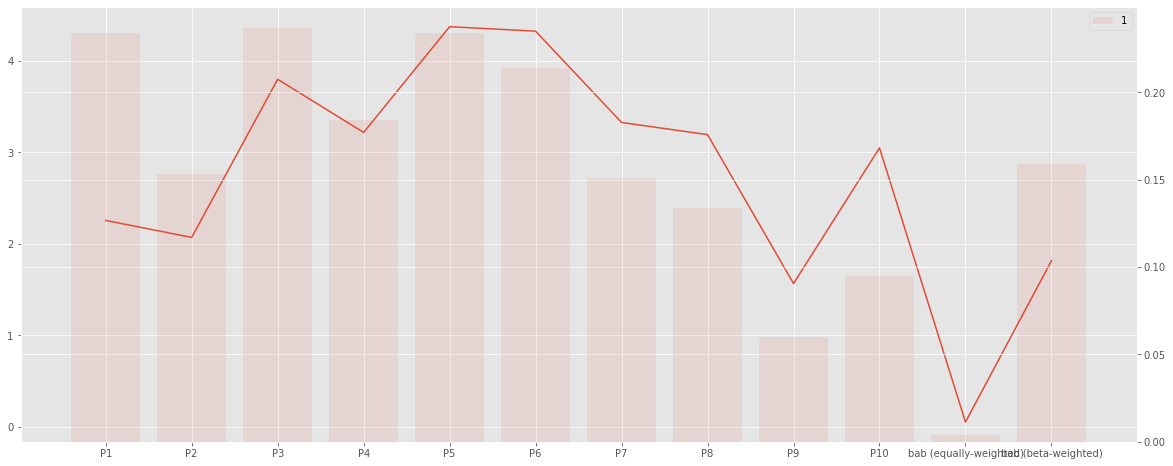

In [116]:
fig, ax1 = plt.subplots(figsize = (20,8))

ax1.plot(portoflio_summary.loc['Excess return'].index,portoflio_summary.loc['Excess return'], label = '1')

ax2 = ax1.twinx()
ax2.bar(portoflio_summary.loc['Sharpe Ratio'].index,portoflio_summary.loc['Sharpe Ratio'], alpha = 0.1,label = '1')

plt.legend()

In [117]:
import seaborn as sns

In [124]:
bab_yearly = pd.DataFrame(bab_monthly)
bab_yearly.index.name = 'Date'
bab_yearly.columns = ['return']
bab_yearly['Year'] = bab_yearly.index.year
bab_yearly = bab_yearly.groupby('Year')['return'].apply(lambda x: (1+x).cumprod().iloc[-1] - 1)
bab_yearly = pd.DataFrame(bab_yearly)
bab_yearly = bab_yearly.reset_index()
bab_yearly 

,Year,return
0,2008,-0.216136
1,2009,0.099371
2,2010,-0.038244
3,2011,0.165084
4,2012,0.096258
5,2013,-0.035087
6,2014,0.131406
7,2015,0.149477
8,2016,-0.017207
9,2017,0.056954


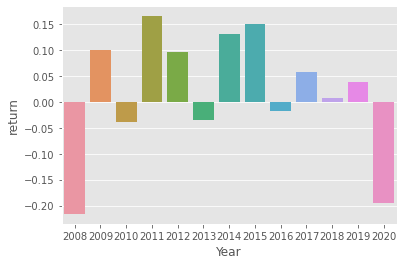

In [125]:
sns.barplot(x = 'Year', y = 'return', data = bab_yearly, ci = False)

In [128]:
df_portfolios = df_quantiles.copy()
df_portfolios = df_portfolios.rename(columns = {'P11':'bab (equally-weighted)','P12':'bab (beta-weighted)' })
df_portfolios

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,bab (equally-weighted),bab (beta-weighted)
Date,,,,,,,,,,,,
2008-01-31,0.023110,-0.038493,-0.067202,-0.061176,-0.074540,-0.067185,-0.063140,-0.062530,-0.072583,-0.064984,0.022424,0.014677
2008-02-29,-0.042214,-0.021336,-0.017762,-0.027488,-0.042030,-0.028429,-0.053016,-0.044889,-0.041304,-0.022748,0.007911,-0.019325
2008-03-31,0.001365,-0.046651,-0.028912,-0.032608,-0.025496,-0.010130,-0.014699,-0.001982,-0.010356,-0.007401,-0.017546,-0.032221
2008-04-30,0.013590,0.026646,0.015824,0.019809,0.041596,0.034968,0.036447,0.023714,0.036598,0.051163,-0.013085,-0.000993
2008-05-30,0.011019,0.014360,0.019205,0.031147,0.027917,0.036255,0.020798,0.027237,0.023486,0.029837,-0.006793,0.006405
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-31,0.001581,0.007383,0.014954,0.023929,0.036360,0.039698,0.038371,0.054097,0.058461,0.080700,-0.037424,-0.036874
2020-09-30,-0.005071,-0.022084,-0.026238,-0.030722,-0.035094,-0.036083,-0.039711,-0.043973,-0.049147,-0.065475,0.023036,0.015407
2020-10-30,-0.014685,-0.000563,-0.007947,-0.000277,-0.012368,0.008581,0.012459,0.014389,0.018657,0.002547,-0.018495,-0.020346


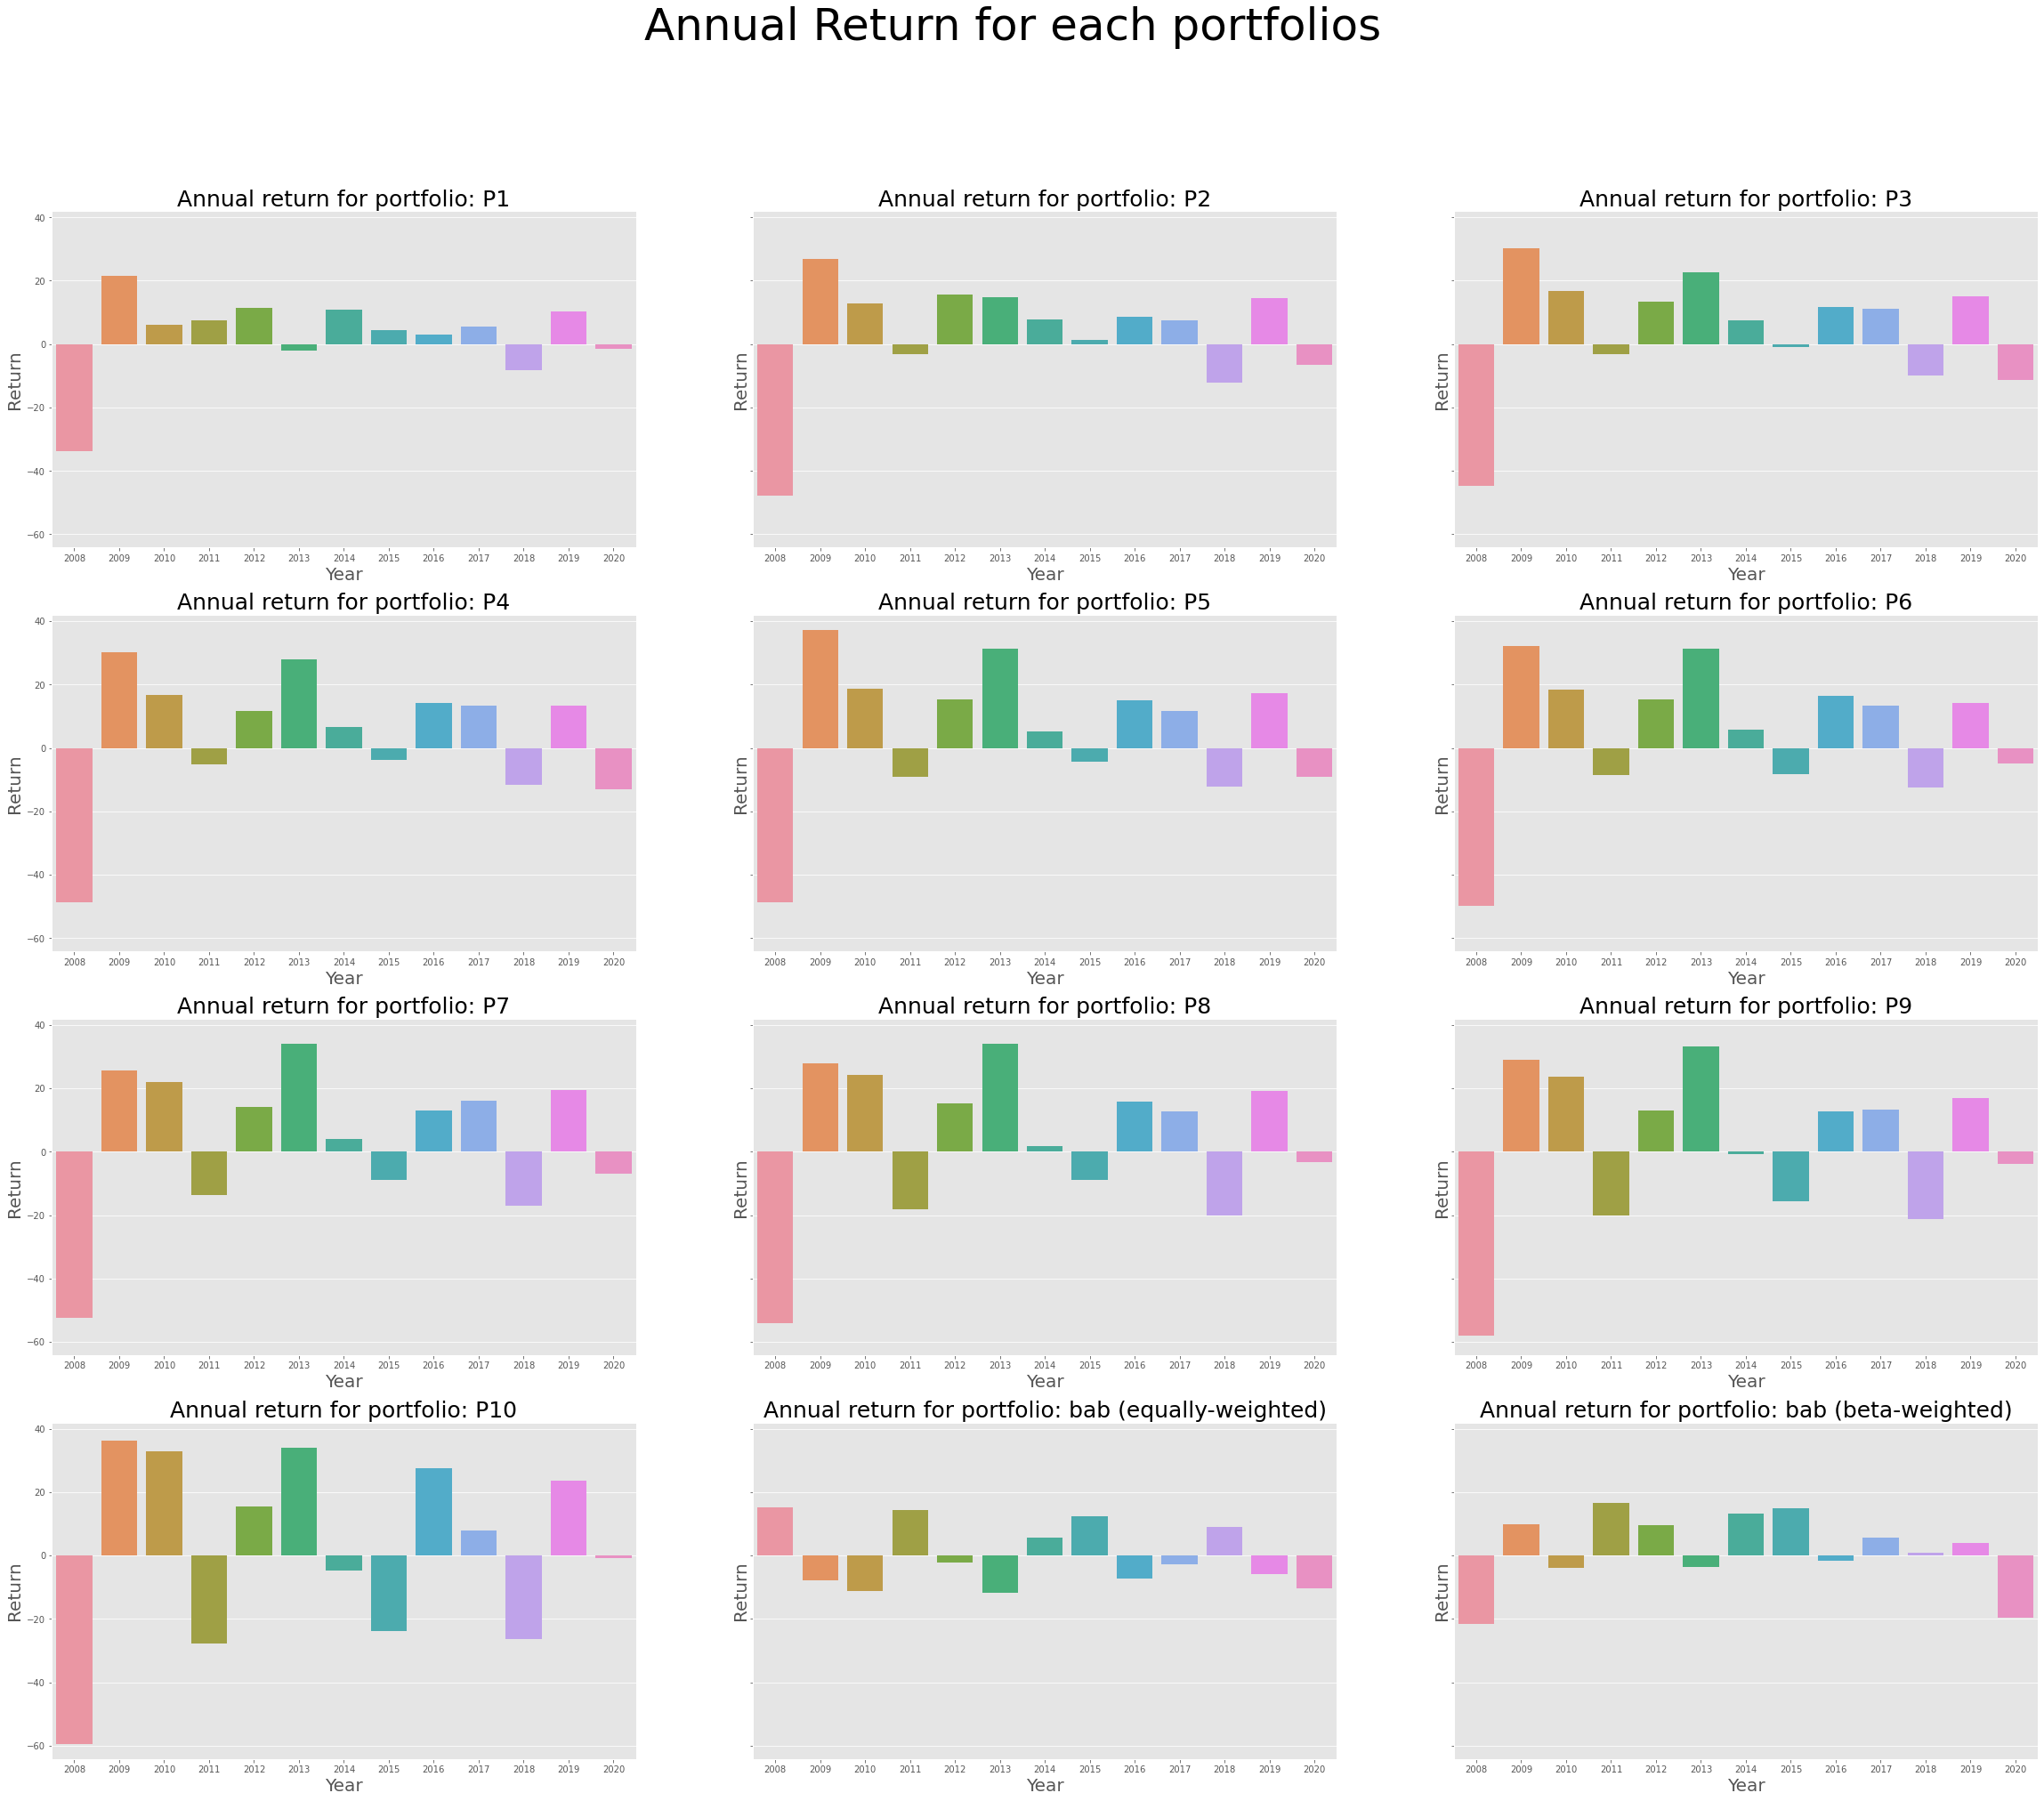

In [196]:
fig, axs = plt.subplots(4,3,figsize = (40,32), sharey = True)

fig.suptitle('Annual Return for each portfolios', fontsize = 50)
for idx,portfolio in enumerate(df_portfolios.columns):
    portfolio_yearly = pd.DataFrame(df_portfolios[portfolio])
    portfolio_yearly.index.name = 'Date'
    portfolio_yearly.columns = ['return']
    portfolio_yearly['Year'] = portfolio_yearly.index.year
    portfolio_yearly = portfolio_yearly.groupby('Year')['return'].apply(lambda x: (1+x).cumprod().iloc[-1] - 1)
    portfolio_yearly = pd.DataFrame(portfolio_yearly * 100)
    portfolio_yearly = portfolio_yearly.reset_index()
    sns.barplot(x = 'Year', y = 'return', data = portfolio_yearly, ci = False, ax = axs[idx//3,idx%3])
    axs[idx//3,idx%3].set_title('Annual return for portfolio: ' + portfolio, fontsize=25)
    axs[idx//3,idx%3].set_xlabel('Year', fontsize = 20)
    axs[idx//3,idx%3].set_ylabel('Return', fontsize = 20)

    